# Fetching the journeys data for analysis

Download the CSV data from TfL, and save in a GeoPandas geodataframe.


In [30]:
# Converts journeys into geometry

import os
import csv
import json
import urllib.request
from requests import get

import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt

from shapely.geometry import LineString

In [2]:
# set paths
DL_path = "data/cycles/DL_data"
points_path = "data/cycles/points"
points_fn = "BikePoints.geojson"
journeys_path = "data/cycles/journeys"

# set source URL and filename
source_url = "https://cycling.data.tfl.gov.uk/usage-stats/"
source_fn = [
    "346JourneyDataExtract28Nov2022-04Dec2022.csv",
    "347JourneyDataExtract05Dec2022-11Dec2022.csv",
    "348JourneyDataExtract12Dec2022-18Dec2022.csv",
    "349JourneyDataExtract19Dec2022-25Dec2022.csv",
    "350JourneyDataExtract26Dec2022-01Jan2023.csv",
    "351JourneyDataExtract02Jan2023-08Jan2023.csv",
    "352JourneyDataExtract09Jan2023-15Jan2023.csv",
    "353JourneyDataExtract16Jan2023-22Jan2023.csv",
    "354JourneyDataExtract23Jan2023-29Jan2023.csv",
    "355JourneyDataExtract30Jan2023-05Feb2023.csv",
    "356JourneyDataExtract06Feb2023-12Feb2023.csv",
    "357JourneyDataExtract13Feb2023-19Feb2023.csv",
    "358JourneyDataExtract20Feb2023-26Feb2023.csv",
    "359JourneyDataExtract27Feb2023-05Mar2023.csv",
    "360JourneyDataExtract06Mar2023-12Mar2023.csv",
    "361JourneyDataExtract13Mar2023-19Mar2023.csv",
    "362JourneyDataExtract20Mar2023-26Mar2023.csv",
    "363JourneyDataExtract27Mar2023-02Apr2023.csv",
    "364JourneyDataExtract03Apr2023-09Apr2023.csv",
    "365JourneyDataExtract10Apr2023-16Apr2023.csv",
    "366JourneyDataExtract17Apr2023-23Apr2023.csv",
    "367JourneyDataExtract24Apr2023-30Apr2023.csv",
    "368JourneyDataExtract01May2023-07May2023.csv",
    "369JourneyDataExtract08May2023-14May2023.csv",
    "370JourneyDataExtract15May2023-21May2023.csv",
    "371JourneyDataExtract22May2023-28May2023.csv",
    "372JourneyDataExtract29May2023-04Jun2023.csv",
    "373JourneyDataExtract05Jun2023-11Jun2023.csv",
    "374JourneyDataExtract12Jun2023-18Jun2023.csv",
    "375JourneyDataExtract19Jun2023-30Jun2023.csv",
    "376JourneyDataExtract01Jul2023-14Jul2023.csv",
    "377JourneyDataExtract15Jul2023-31Jul2023.csv",
    "378JourneyDataExtract01Aug2023-14Aug2023.csv",
    "378JourneyDataExtract15Aug2023-31Aug2023.csv",
    "379JourneyDataExtract01Sep2023-14Sep2023.csv",
    "380JourneyDataExtract15Sep2023-30Sep2023.csv",
    "381JourneyDataExtract01Oct2023-14Oct2023.csv",
    "382JourneyDataExtract15Oct2023-31Oct2023.csv",
    "383JourneyDataExtract01Nov2023-14Nov2023.csv",
    "384JourneyDataExtract15Nov2023-30Nov2023.csv"
]

In [3]:
# download journeys

# creates saving directory if does not exist
if not os.path.exists(journeys_path):
    os.makedirs(journeys_path)


for fn in source_fn:
    # check if local exists
    if not os.path.exists(os.path.join(journeys_path, fn)):
        source = source_url + fn
        print(f"Downloading   : {fn}")
        with open(os.path.join(journeys_path, fn), "wb") as file:
            response = get(source)
            file.write(response.content)
    else:
        print(f"Found in local: {fn}")

print('Done')

Found in local: 346JourneyDataExtract28Nov2022-04Dec2022.csv
Found in local: 347JourneyDataExtract05Dec2022-11Dec2022.csv
Found in local: 348JourneyDataExtract12Dec2022-18Dec2022.csv
Found in local: 349JourneyDataExtract19Dec2022-25Dec2022.csv
Found in local: 350JourneyDataExtract26Dec2022-01Jan2023.csv
Found in local: 351JourneyDataExtract02Jan2023-08Jan2023.csv
Found in local: 352JourneyDataExtract09Jan2023-15Jan2023.csv
Found in local: 353JourneyDataExtract16Jan2023-22Jan2023.csv
Found in local: 354JourneyDataExtract23Jan2023-29Jan2023.csv
Found in local: 355JourneyDataExtract30Jan2023-05Feb2023.csv
Found in local: 356JourneyDataExtract06Feb2023-12Feb2023.csv
Found in local: 357JourneyDataExtract13Feb2023-19Feb2023.csv
Found in local: 358JourneyDataExtract20Feb2023-26Feb2023.csv
Found in local: 359JourneyDataExtract27Feb2023-05Mar2023.csv
Found in local: 360JourneyDataExtract06Mar2023-12Mar2023.csv
Found in local: 361JourneyDataExtract13Mar2023-19Mar2023.csv
Found in local: 362Journ

## Create dataframe from journeys

In [6]:
# test flag
test_flag = 1

# load data
if test_flag == 1:
    journeys_df = pd.read_csv(os.path.join(journeys_path, source_fn[0]))

else:
    journeys_df = pd.DataFrame()
    for fn in source_fn:
        journeys_df = pd.concat([journeys_df, pd.read_csv(os.path.join(journeys_path, fn), low_memory = False)])


In [8]:
# clean data

# clean dates
dates = ['Start date', 'End date']

for d in dates:
    journeys_df[d] = pd.to_datetime(journeys_df[d], format = '%Y-%m-%d %H:%M')

In [10]:
# make bike model into categorical data
# this should only have 2 types: 'CLASSIC' and 'PBSC_EBIKE'
journeys_df['Bike model'] = journeys_df['Bike model'].astype('category')

In [19]:
journeys_df

,Number,Start date,Start station number,Start station,End date,End station number,End station,Bike number,Bike model,Total duration,Total duration (ms)
0,127293434,2022-12-04 23:59:00,1194,"Westminster University, Marylebone",2022-12-05 00:08:00,300079,"London Street, Paddington",24140,CLASSIC,9m 5s,545098
1,127293435,2022-12-04 23:59:00,22169,"Wren Street, Holborn",2022-12-05 00:07:00,1052,"Soho Square , Soho",58765,CLASSIC,7m 32s,452636
2,127293433,2022-12-04 23:58:00,1152,"Marylebone Lane, Marylebone",2022-12-05 00:14:00,1182,"Notting Hill Gate Station, Notting Hill",57158,CLASSIC,15m 45s,945616
3,127293430,2022-12-04 23:57:00,200250,"Cleveland Way, Stepney",2022-12-05 00:02:00,200131,"Clarkson Street, Bethnal Green",55233,CLASSIC,5m 3s,303946
4,127293431,2022-12-04 23:57:00,200072,"Houndsditch, Aldgate",2022-12-05 00:01:00,1105,"LMU Commercial Road, Whitechapel",59082,CLASSIC,3m 15s,195554
...,...,...,...,...,...,...,...,...,...,...,...
163358,127124669,2022-11-28 00:00:00,1109,"Wellington Arch, Hyde Park",2022-11-28 00:30:00,200096,"Green Park Station, Mayfair",55349,CLASSIC,29m 50s,1790970
163359,127124670,2022-11-28 00:00:00,300207,"Gauden Road, Clapham",2022-11-28 00:08:00,200023,"Heath Road, Battersea",58973,CLASSIC,8m 25s,505518
163360,127124671,2022-11-28 00:00:00,200041,"Antill Road, Mile End",2022-11-28 00:05:00,200174,"Mostyn Grove, Bow",40131,CLASSIC,4m 59s,299952
163361,127124672,2022-11-28 00:00:00,300245,"Clapham Road, Lingham Street, Stockwell",2022-11-28 00:07:00,300247,"Cranmer Road, Stockwell",21823,CLASSIC,6m 59s,419129


## Join with height data

In [21]:
# set path
points_path = 'data/cycles/points'
points_parquet_fn = 'docking_stations.geoparquet'

# load points gdf
points_gdf = gpd.read_parquet(os.path.join(points_path, points_parquet_fn))


In [22]:
points_gdf

,id,name,ports,geometry,location,zone,height
0,001023,"River Street , Clerkenwell",19,POINT (531203.555 182832.015),River Street,Clerkenwell,32.264999
1,001018,"Phillimore Gardens, Kensington",37,POINT (525208.086 179391.817),Phillimore Gardens,Kensington,11.532250
2,001012,"Christopher Street, Liverpool Street",32,POINT (532985.858 182001.488),Christopher Street,Liverpool Street,16.526251
3,001013,"St. Chad's Street, King's Cross",23,POINT (530437.806 182911.996),St. Chad's Street,King's Cross,17.187750
4,003420,"Sedding Street, Sloane Square",27,POINT (528050.966 178742.004),Sedding Street,Sloane Square,5.821500
...,...,...,...,...,...,...,...
795,001100,"Strand, Strand",35,POINT (530898.208 180979.048),Strand,Strand,14.308000
796,200077,"Vicarage Crescent, Battersea",30,POINT (526760.999 176455.972),Vicarage Crescent,Battersea,4.417750
797,001064,"Old Street Station, St. Luke's",34,POINT (532700.842 182476.096),Old Street Station,St. Luke's,17.792250
798,003501,"Clifton Street, Shoreditch",24,POINT (533086.981 182217.013),Clifton Street,Shoreditch,16.034500


In [24]:
# merge the points data to the journeys data

# merge the start point data
journeys_df_merged = journeys_df.merge(points_gdf.add_prefix('start_'), left_on = 'Start station', right_on = 'start_name')

# merge the end point data
journeys_df_merged = journeys_df_merged.merge(points_gdf.add_prefix('end_'), left_on = 'End station', right_on = 'end_name')

journeys_df_merged

,Number,Start date,Start station number,Start station,End date,End station number,End station,Bike number,Bike model,Total duration,...,start_location,start_zone,start_height,end_id,end_name,end_ports,end_geometry,end_location,end_zone,end_height
0,127293434,2022-12-04 23:59:00,1194,"Westminster University, Marylebone",2022-12-05 00:08:00,300079,"London Street, Paddington",24140,CLASSIC,9m 5s,...,Westminster University,Marylebone,27.505249,300079,"London Street, Paddington",19,POINT (526821.250 181157.755),London Street,Paddington,26.3120
1,127256557,2022-12-02 20:06:00,1085,"Old Quebec Street, Marylebone",2022-12-02 20:11:00,300079,"London Street, Paddington",51668,CLASSIC,5m 17s,...,Old Quebec Street,Marylebone,27.112749,300079,"London Street, Paddington",19,POINT (526821.250 181157.755),London Street,Paddington,26.3120
2,127222561,2022-12-01 15:48:00,1085,"Old Quebec Street, Marylebone",2022-12-01 15:54:00,300079,"London Street, Paddington",57546,CLASSIC,5m 24s,...,Old Quebec Street,Marylebone,27.112749,300079,"London Street, Paddington",19,POINT (526821.250 181157.755),London Street,Paddington,26.3120
3,127198699,2022-11-30 18:05:00,1085,"Old Quebec Street, Marylebone",2022-11-30 18:11:00,300079,"London Street, Paddington",52833,CLASSIC,6m 37s,...,Old Quebec Street,Marylebone,27.112749,300079,"London Street, Paddington",19,POINT (526821.250 181157.755),London Street,Paddington,26.3120
4,127193452,2022-11-30 15:44:00,1085,"Old Quebec Street, Marylebone",2022-11-30 15:49:00,300079,"London Street, Paddington",55552,CLASSIC,5m 18s,...,Old Quebec Street,Marylebone,27.112749,300079,"London Street, Paddington",19,POINT (526821.250 181157.755),London Street,Paddington,26.3120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159513,127132580,2022-11-28 10:09:00,300226,"Copper Box Arena, Queen Elizabeth Olympic Park",2022-11-28 10:12:00,300219,"Here East South, Queen Elizabeth Olympic Park",40028,CLASSIC,2m 52s,...,Copper Box Arena,Queen Elizabeth Olympic Park,10.278749,300219,"Here East South, Queen Elizabeth Olympic Park",28,POINT (537350.344 184927.413),Here East South,Queen Elizabeth Olympic Park,9.4975
159514,127281432,2022-12-04 10:19:00,300219,"Here East South, Queen Elizabeth Olympic Park",2022-12-04 10:38:00,300219,"Here East South, Queen Elizabeth Olympic Park",50956,CLASSIC,18m 42s,...,Here East South,Queen Elizabeth Olympic Park,9.497500,300219,"Here East South, Queen Elizabeth Olympic Park",28,POINT (537350.344 184927.413),Here East South,Queen Elizabeth Olympic Park,9.4975
159515,127272102,2022-12-03 16:21:00,300219,"Here East South, Queen Elizabeth Olympic Park",2022-12-03 17:35:00,300219,"Here East South, Queen Elizabeth Olympic Park",58934,CLASSIC,1h 14m 9s,...,Here East South,Queen Elizabeth Olympic Park,9.497500,300219,"Here East South, Queen Elizabeth Olympic Park",28,POINT (537350.344 184927.413),Here East South,Queen Elizabeth Olympic Park,9.4975
159516,127265715,2022-12-03 12:22:00,300219,"Here East South, Queen Elizabeth Olympic Park",2022-12-03 13:06:00,300219,"Here East South, Queen Elizabeth Olympic Park",58934,CLASSIC,44m 3s,...,Here East South,Queen Elizabeth Olympic Park,9.497500,300219,"Here East South, Queen Elizabeth Olympic Park",28,POINT (537350.344 184927.413),Here East South,Queen Elizabeth Olympic Park,9.4975


In [26]:
# calculate the height difference

journeys_df_merged['height_diff'] = journeys_df_merged.end_height - journeys_df_merged.start_height

In [28]:
journeys_df_merged.height_diff.describe()

count    159518.000000
mean         -0.224143
std           9.062005
min         -43.039997
25%          -4.157875
50%           0.000000
75%           3.783250
max          42.481998
Name: height_diff, dtype: float64

In [63]:
# get the geometry for each journey

journeys_df_merged['geometry'] = pd.Series()

for index, row in journeys_df_merged.iterrows():
#    if row['start_name'] != row['end_name']:
        journeys_df_merged.loc[index, 'geometry'] = LineString([row['start_geometry'], row['end_geometry']])
#    else:
#        journeys_df_merged.loc[index, 'geometry'] = row['start_geometry']        

In [56]:
journeys_df_merged.columns

Index(['Number', 'Start date', 'Start station number', 'Start station',
       'End date', 'End station number', 'End station', 'Bike number',
       'Bike model', 'Total duration', 'Total duration (ms)', 'start_id',
       'start_name', 'start_ports', 'start_geometry', 'start_location',
       'start_zone', 'start_height', 'end_id', 'end_name', 'end_ports',
       'end_geometry', 'end_location', 'end_zone', 'end_height', 'height_diff',
       'geometry'],
      dtype='object')

In [64]:
# create geodataframe
columns = ['Number', 'Start date', 'Start station number', 'start_location', 'start_zone', 'start_height',
           'End date', 'End station number', 'end_location', 'end_zone', 'Bike number', 'end_height', 
           'Bike model', 'Total duration (ms)', 'height_diff', 'geometry']

journeys_gdf = gpd.GeoDataFrame(journeys_df_merged[columns], crs = 'EPSG:27700')


In [83]:
journeys_gdf['distance'] = journeys_gdf.length

<Axes: xlabel='distance', ylabel='height_diff'>

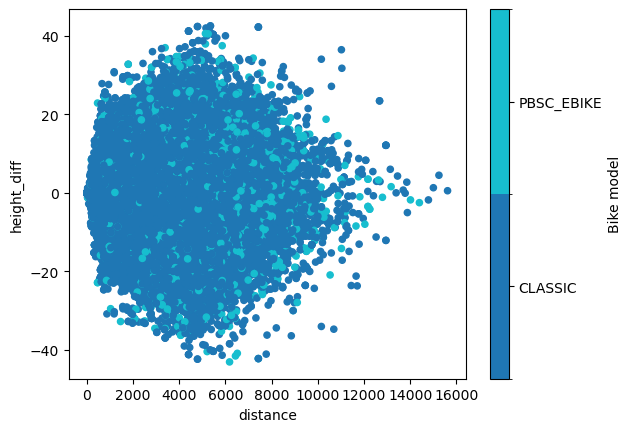

In [85]:
journeys_gdf.plot.scatter(x = 'distance', y = 'height_diff', c = 'Bike model', cmap = 'tab10')